In [135]:
import numpy as np
import pandas as pd
import math

In [136]:
import tensorflow as tf 

In [137]:
from tensorflow.keras import backend as K

In [138]:
df = pd.read_csv('C:\TPC_GAN_SIM\TPC-GAN-SIM\Data\digits.csv')

In [139]:
df.describe()

,evtId,ipad,itime,amp,crossing_angle,dip_angle,drift_length,pad_coordinate
count,544513.000000,544513.000000,544513.000000,544513.000000,544513.000000,544513.000000,544513.000000,544513.000000
mean,9998.116271,43.191593,172.717893,243.400471,-0.057631,-0.505002,172.718675,43.191624
std,5767.839085,1.540539,72.647436,639.426251,11.693803,36.664225,72.613729,1.152069
min,0.000000,39.000000,31.000000,1.000000,-20.000000,-59.985000,35.878000,41.192000
25%,5011.000000,42.000000,111.000000,7.362000,-10.357000,-33.817000,110.722000,42.207000
50%,10002.000000,43.000000,177.000000,46.470000,-0.066000,-0.654000,177.216000,43.175000
75%,14987.000000,44.000000,236.000000,260.600000,10.201000,32.684000,236.080000,44.194000
max,19999.000000,48.000000,296.000000,39990.000000,20.099000,59.993000,290.405000,45.192000


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544513 entries, 0 to 544512
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   evtId           544513 non-null  int64  
 1   ipad            544513 non-null  int64  
 2   itime           544513 non-null  int64  
 3   amp             544513 non-null  float64
 4   crossing_angle  544513 non-null  float64
 5   dip_angle       544513 non-null  float64
 6   drift_length    544513 non-null  float64
 7   pad_coordinate  544513 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 33.2 MB


In [141]:
input_features = df.iloc[:,-4:]
input_features

,crossing_angle,dip_angle,drift_length,pad_coordinate
0,-8.695,32.201,35.936,41.844
1,-8.695,32.201,35.936,41.844
2,-8.695,32.201,35.936,41.844
3,-8.695,32.201,35.936,41.844
4,-8.695,32.201,35.936,41.844
...,...,...,...,...
544508,10.016,-12.861,52.403,42.317
544509,10.016,-12.861,52.403,42.317
544510,10.016,-12.861,52.403,42.317
544511,10.016,-12.861,52.403,42.317


In [142]:
def linearity_scaling(pd_series ,  a = -1, b = 1):
    x,y = pd_series.min() , pd_series.max()
    out = (pd_series - x) /(y-x) *(b-a) +a
    return out 
    

In [143]:
def preprocessing_func_as_csv ( features):
    
    temp_features = pd.DataFrame()
    #it is sufficient to only feed the fractional part of the pad coordinate into our model
    temp_features['pad_coordinate'] = features['pad_coordinate'] % 1 
    
    # drift length both the fractional part and the full number are fed into the model as two separate features
    
    temp_features ['drift_length_frac'] = features['drift_length'] % 1
    
    
    
    # the angles and the drift length are linearly scaled down to a [−1, 1] region
    
    columns = ['crossing_angle','dip_angle','drift_length']
    
    for col in columns:
        temp_features[col] = linearity_scaling(features[col])
    
    
    return tf.convert_to_tensor(temp_features)

In [144]:
data_from_csv = preprocessing_func_as_csv(input_features)
data_from_csv

<tf.Tensor: shape=(544513, 5), dtype=float64, numpy=
array([[ 0.844     ,  0.936     , -0.43614554,  0.53671506, -0.99954425],
       [ 0.844     ,  0.936     , -0.43614554,  0.53671506, -0.99954425],
       [ 0.844     ,  0.936     , -0.43614554,  0.53671506, -0.99954425],
       ...,
       [ 0.317     ,  0.403     ,  0.49709469, -0.21445598, -0.8701513 ],
       [ 0.317     ,  0.403     ,  0.49709469, -0.21445598, -0.8701513 ],
       [ 0.317     ,  0.403     ,  0.49709469, -0.21445598, -0.8701513 ]])>

In [145]:
def read_csv_from_path(path):
        df = pd.read_csv(path)
        input_features = df.iloc[:,-4:]
        return input_features.to_numpy(dtype='float32')

In [146]:
def preprocessing_func_as_tensor(input_tensors):
    
    bin_fractions = input_tensors[:, 2:4] % 1
    input_tensors = (input_tensors[:, :3] - tf.constant([[0.0, 0.0, 162.5]])) / tf.constant([[20.0, 60.0, 127.5]])
    return tf.concat([input_tensors, bin_fractions], axis=-1)

In [147]:
temp_features = input_features.to_numpy()

In [148]:
data_tensor = preprocessing_func_as_tensor(temp_features)
data_tensor

<tf.Tensor: shape=(544513, 5), dtype=float32, numpy=
array([[-0.43475  ,  0.5366833, -0.9926588,  0.936    ,  0.844    ],
       [-0.43475  ,  0.5366833, -0.9926588,  0.936    ,  0.844    ],
       [-0.43475  ,  0.5366833, -0.9926588,  0.936    ,  0.844    ],
       ...,
       [ 0.5008   , -0.21435  , -0.8635059,  0.403    ,  0.317    ],
       [ 0.5008   , -0.21435  , -0.8635059,  0.403    ,  0.317    ],
       [ 0.5008   , -0.21435  , -0.8635059,  0.403    ,  0.317    ]],
      dtype=float32)>

In [149]:

'''
custom log with base in tensorflow if there was a problem with the values
def log10(x):
  numerator = tf.log(x)
  denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator
'''

def custom_activation_V1(x , T = math.log10(2), alpha = 0.1, gamma = 0.01 ):
    '''
    if gamma < x :
        T-gamma +x
    elif 0<x<=gamma:
        T * (alpha + ((1- alpha)*(x/gamma)))
    else :
        alpha * T * math.exp(x)
    
    '''
    return K.switch(x> gamma , T - gamma + x , K.switch(x < 0, alpha * T * tf.math.exp(x),T * (alpha + ((1- alpha)*(x/gamma)))))

In [150]:
#testing the activation function 

X = np.random.uniform(0,1, (100,10))
y = np.random.uniform(0,1, 100)

inp = tf.keras.Input((10,))
x = tf.keras.layers.Dense(8, activation=custom_activation_V1)(inp)
out = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inp, out)
model.compile('adam', 'mse')
model.fit(X,y, epochs=3)

Epoch 1/3
4/4 [==============================] - 0s 3ms/step - loss: 1.0789
Epoch 2/3
4/4 [==============================] - 0s 4ms/step - loss: 0.9716
Epoch 3/3
4/4 [==============================] - 0s 3ms/step - loss: 0.8882


In [151]:
def custom_activation_V2 (x, shift = 0.01,val = np.log10(2),val0 = np.log10(2) / 10):
    return tf.where(x> shift,
                    val +x -shift,
                    val0 + tf.keras.activations.elu(
                        x,alpha = (val0 *shift/ (val -val0))
                                                    ) * (val -val0)/shift)

In [152]:
#testing the activation function 

X = np.random.uniform(0,1, (100,10))
y = np.random.uniform(0,1, 100)

inp = tf.keras.Input((10,))
x = tf.keras.layers.Dense(8, activation=custom_activation_V2)(inp)
out = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inp, out)
model.compile('adam', 'mse')
model.fit(X,y, epochs=3)

Epoch 1/3
4/4 [==============================] - 0s 4ms/step - loss: 0.6094
Epoch 2/3
4/4 [==============================] - 0s 3ms/step - loss: 0.5550
Epoch 3/3
4/4 [==============================] - 0s 4ms/step - loss: 0.5040


In [153]:
#Appendix A: Generator


# attention, care that last dense layer function should be more described 
def create_generator_structure():
    
    generator = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(32, activation='elu', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dense(64,activation='elu', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dense(64,activation='elu', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dense(64,activation='elu', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dense(8*16,activation=custom_activation_V2, kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Reshape(target_shape= (8,16))
        ],
        name= 'generator'
    )
    return generator

In [154]:
model = create_generator_structure()
model.build(input_shape= (37,1))
model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (37, 32)                  64        
                                                                 
 dense_98 (Dense)            (37, 64)                  2112      
                                                                 
 dense_99 (Dense)            (37, 64)                  4160      
                                                                 
 dense_100 (Dense)           (37, 64)                  4160      
                                                                 
 dense_101 (Dense)           (37, 128)                 8320      
                                                                 
 reshape_22 (Reshape)        (37, 8, 16)               0         
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainab

In [155]:
#Appendix A: discriminator

def create_discriminator_structure():
    input_img = tf.keras.Input(shape= (8,16))
    features = tf.keras.Input(shape= (5,))    
    
    # reshaping 
    
    # remarks : If one component of shape is the special value -1, the size of that dimension is computed so that the total size remains constant. In particular, a shape of [-1] flattens into 1-D. At most one component of shape can be -1.
    
    
    img = tf.reshape(input_img, (-1,8,16,1))
    
    
    features_Tiled = tf.tile((tf.reshape(features, (-1,1,1,5))), (1,8,16,1))
    
    # remarks : Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
    # remarks : The rank of a tensor is the number of indices required to uniquely select each element of the tensor.

    input_img = tf.concat([img,features_Tiled],-1) 
    
    
    
    
    
    discriminator_main = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(activation='elu', kernel_size=(3,3),filters= 16 , padding='same', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dropout(0.02),
            
            tf.keras.layers.Conv2D(activation='elu',kernel_size= (3,3),filters=16, padding='same', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dropout(0.02),
            
            tf.keras.layers.MaxPool2D(pool_size=(1,2)),
            
            tf.keras.layers.Conv2D(activation='elu', kernel_size=(3,3),filters= 32 , padding='same', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dropout(0.02),
            
            tf.keras.layers.Conv2D(activation='elu',kernel_size= (3,3),filters=32, padding='same', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dropout(0.02),
            
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            
            tf.keras.layers.Conv2D(activation='elu', kernel_size=(3,3),filters= 64 , padding='valid', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dropout(0.02),
            
            tf.keras.layers.Conv2D(activation='elu',kernel_size= (2,2),filters=64, padding='valid', kernel_initializer= 'glorot_uniform'),
            tf.keras.layers.Dropout(0.02),
            
            tf.keras.layers.Reshape(target_shape=(64,))
        ],
        name= 'discriminator_main'
    )
    
    head_input  = tf.keras.layers.Concatenate()([features,discriminator_main(input_img)])
    
    head_layers  = [
        tf.keras.layers.Dense(128,activation='elu'),
        tf.keras.layers.Dropout(0.02),
        
        
        tf.keras.layers.Dense(1,activation=None)
    ]
    
    discriminator_head = tf.keras.Sequential(
        head_layers,
        name = 'discriminator_head'
    )
    
    inputs = [features, input_img]
    outputs = discriminator_head(head_input)
    
    discriminator = tf.keras.Model(inputs=inputs, outputs=outputs, name='discriminator')

    return discriminator
    
    
     

In [156]:
model = create_discriminator_structure()
model.build(input_shape=(1,8,16,1))
model.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 8, 16, 6)]   0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 discriminator_main (Sequential  (None, 64)          52032       ['input_47[0][0]']               
 )                                                                                                
                                                                                                  
 concatenate_11 (Concatenate)   (None, 69)           0           ['input_46[0][0]',   

In [157]:
def gen_loss (fake,real):
    #return tf.reduce_mean (real) - tf.reduce_mean(fake)
    return tf.reduce_mean (real - fake)

In [158]:
def disc_loss (fake, real):
    #return tf.reduce_mean (real) - tf.reduce_mean(fake)
    return tf.reduce_mean (fake - real)
   

In [161]:
class GAN_Model:
    def __init__(self) -> None:
        self.preprocess_function = preprocessing_func_as_tensor
        
        self.latent_dim = 32
        self.batch_size = 32
        
        # We train both generator and discriminator using RMSprop optimizer with learning rates starting at 0.0001
        
        self.lr = 1.e-4
        self.lr_schedule = 0.999
        self.disc_opt = tf.keras.optimizers.RMSprop(learning_rate= self.lr)
        self.gen_opt = tf.keras.optimizers.RMSprop (learning_rate= self.lr)
        
        # gradient penalty value
        self.lambda_value = 10
        
        #We make 8 discriminator update steps per single generator step.
        self.num_update_step = 8
        
        
        self.latent_dim = 32
        self.batch_size = 32
        
        
        self.num_epochs = 10000
        
        self.generator = create_generator_structure()
        self.discriminator = create_discriminator_structure()
        
        
        self.step_counter = tf.Variable(0, dtype='int32', trainable=False)
        
        self.pad_range = tuple([-3, 5])
        self.time_range = tuple([-7, 9])
        
        
        self.generator.compile(optimizer=self.gen_opt, loss='mean_squared_error')
        self.discriminator.compile(optimizer=self.disc_opt, loss='mean_squared_error')
    
    
        
    
    def make_fake (self,features):
        size = tf.shape(features)[0]
        latent_input = tf.random.normal(shape=(size,self.latent_dim),dtype='float32')
        return tf.concat([self.preprocess_function(features), latent_input],axis= -1)
        
        
    def gradient_penalty(self, features, real, fake):
        alpha = tf.random.uniform(shape=[len(real)] + [1] * (len(real.shape) - 1))
        interpolates = alpha * real + (1 - alpha) * fake
        with tf.GradientTape() as t:
            t.watch(interpolates)
            d_int = self.discriminator([self._f(features), interpolates])

        grads = tf.reshape(t.gradient(d_int, interpolates), [len(real), -1])
        return tf.reduce_mean(tf.maximum(tf.norm(grads, axis=-1) - 1, 0) ** 2)
    
    
    

In [162]:
model = GAN_Model ()
model.make_fake(read_csv_from_path('C:\TPC_GAN_SIM\TPC-GAN-SIM\Data\digits.csv'))



<tf.Tensor: shape=(544513, 37), dtype=float32, numpy=
array([[-0.43475   ,  0.5366833 , -0.9926588 , ...,  0.1522311 ,
         0.67881995,  0.26531002],
       [-0.43475   ,  0.5366833 , -0.9926588 , ...,  1.1984749 ,
        -0.989147  , -2.6547477 ],
       [-0.43475   ,  0.5366833 , -0.9926588 , ...,  0.52445495,
        -1.3819119 ,  0.12375331],
       ...,
       [ 0.5008    , -0.21435   , -0.8635059 , ...,  0.07197028,
        -0.838891  , -1.5447116 ],
       [ 0.5008    , -0.21435   , -0.8635059 , ..., -0.14641945,
        -0.4717252 , -0.21004741],
       [ 0.5008    , -0.21435   , -0.8635059 , ..., -2.729691  ,
        -1.0241101 , -1.5531155 ]], dtype=float32)>

# Testing CSV reading 

In [200]:
df = pd.read_csv('C:\TPC_GAN_SIM\TPC-GAN-SIM\Data\digits.csv')

In [201]:
def sel(df, col, limits):
        return (df[col] >= limits[0]) & (df[col] < limits[1])

In [202]:
df

,evtId,ipad,itime,amp,crossing_angle,dip_angle,drift_length,pad_coordinate
0,0,41,33,7.695,-8.695,32.201,35.936,41.844
1,0,41,34,83.630,-8.695,32.201,35.936,41.844
2,0,41,35,247.400,-8.695,32.201,35.936,41.844
3,0,41,36,273.400,-8.695,32.201,35.936,41.844
4,0,41,37,131.000,-8.695,32.201,35.936,41.844
...,...,...,...,...,...,...,...,...
544508,19999,43,51,282.400,10.016,-12.861,52.403,42.317
544509,19999,43,52,693.800,10.016,-12.861,52.403,42.317
544510,19999,43,53,505.400,10.016,-12.861,52.403,42.317
544511,19999,43,54,135.700,10.016,-12.861,52.403,42.317


In [203]:
 if 'drift_length' in df.columns:
    df['itime'] -= df['drift_length'].astype(int)

In [204]:
df

,evtId,ipad,itime,amp,crossing_angle,dip_angle,drift_length,pad_coordinate
0,0,41,-2,7.695,-8.695,32.201,35.936,41.844
1,0,41,-1,83.630,-8.695,32.201,35.936,41.844
2,0,41,0,247.400,-8.695,32.201,35.936,41.844
3,0,41,1,273.400,-8.695,32.201,35.936,41.844
4,0,41,2,131.000,-8.695,32.201,35.936,41.844
...,...,...,...,...,...,...,...,...
544508,19999,43,-1,282.400,10.016,-12.861,52.403,42.317
544509,19999,43,0,693.800,10.016,-12.861,52.403,42.317
544510,19999,43,1,505.400,10.016,-12.861,52.403,42.317
544511,19999,43,2,135.700,10.016,-12.861,52.403,42.317


In [205]:
if 'pad_coordinate' in df.columns:
    df['ipad'] -= df['pad_coordinate'].astype(int)
df

,evtId,ipad,itime,amp,crossing_angle,dip_angle,drift_length,pad_coordinate
0,0,0,-2,7.695,-8.695,32.201,35.936,41.844
1,0,0,-1,83.630,-8.695,32.201,35.936,41.844
2,0,0,0,247.400,-8.695,32.201,35.936,41.844
3,0,0,1,273.400,-8.695,32.201,35.936,41.844
4,0,0,2,131.000,-8.695,32.201,35.936,41.844
...,...,...,...,...,...,...,...,...
544508,19999,1,-1,282.400,10.016,-12.861,52.403,42.317
544509,19999,1,0,693.800,10.016,-12.861,52.403,42.317
544510,19999,1,1,505.400,10.016,-12.861,52.403,42.317
544511,19999,1,2,135.700,10.016,-12.861,52.403,42.317


In [206]:
pad_range=(-3, 5)
time_range=(-7, 9)

In [207]:
selection = sel(df, 'itime', time_range) & sel(df, 'ipad', pad_range)
g = df[selection].groupby('evtId')
g

In [208]:
 bad_ids = df[~selection]['evtId'].unique()
 bad_ids

array([], dtype=int64)

In [209]:
anti_selection = df['evtId'].apply(lambda x: x in bad_ids)
anti_selection

0         False
1         False
2         False
3         False
4         False
          ...  
544508    False
544509    False
544510    False
544511    False
544512    False
Name: evtId, Length: 544513, dtype: bool

In [210]:
anti_g = df[anti_selection].groupby('evtId')

In [211]:
strict = True
if not selection.all():
        msg = (
            f"WARNING: current selection ignores {(~selection).sum() / len(selection) * 100}% of the data"
            f" ({len(anti_g)} events)!"
        )
        assert not strict, msg
        print(msg)

In [214]:
def convert_event(event):
        result = np.zeros(dtype=float, shape=(pad_range[1] - pad_range[0], time_range[1] - time_range[0]))
        #print (result.shape)
        indices = tuple(event[['ipad', 'itime']].values.T - np.array([[pad_range[0]], [time_range[0]]]))
        
        #print ('-----------')
        #print (indices)
        result[indices] = event.amp.values

        return result

In [220]:
data = np.stack(g.apply(convert_event).values)
data.shape

C:\Users\kakas\AppData\Local\Temp\ipykernel_18944\1072927715.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = np.stack(g.apply(convert_event).values)


(20000, 8, 16)

In [218]:
anti_data = None
misc_out=None

In [219]:
if not selection.all() and misc_out is not None:
        assert isinstance(misc_out, dict)
        pad_range = [df[anti_selection]["ipad"].min(), df[anti_selection]["ipad"].max() + 1]
        time_range = [df[anti_selection]["itime"].min(), df[anti_selection]["itime"].max() + 1]
        anti_data = np.stack(anti_g.apply(convert_event).values)
        misc_out["anti_data"] = anti_data
        misc_out["bad_ids"] = bad_ids

In [221]:
if 'crossing_angle' in df.columns:
        features = ['crossing_angle', 'dip_angle']
        if 'drift_length' in df.columns:
            features += ['drift_length']
        if 'pad_coordinate' in df.columns:
            features += ['pad_coordinate']
        if "row" in df.columns:
            features += ["row"]
        if "pT" in df.columns:
            features += ["pT"]
        assert (
            (g[features].std() == 0).all(axis=1) | (g[features].size() == 1)
        ).all(), 'Varying features within same events...'

In [223]:
features = g[features].mean().values

In [224]:
features.shape

(20000, 4)

In [1]:
img_shape = tuple([8, 16])

In [9]:
print (1, img_shape[0],img_shape[1], 1)

1 8 16 1


In [2]:
import matplotlib.pyplot as plt

12 28.799999999999997


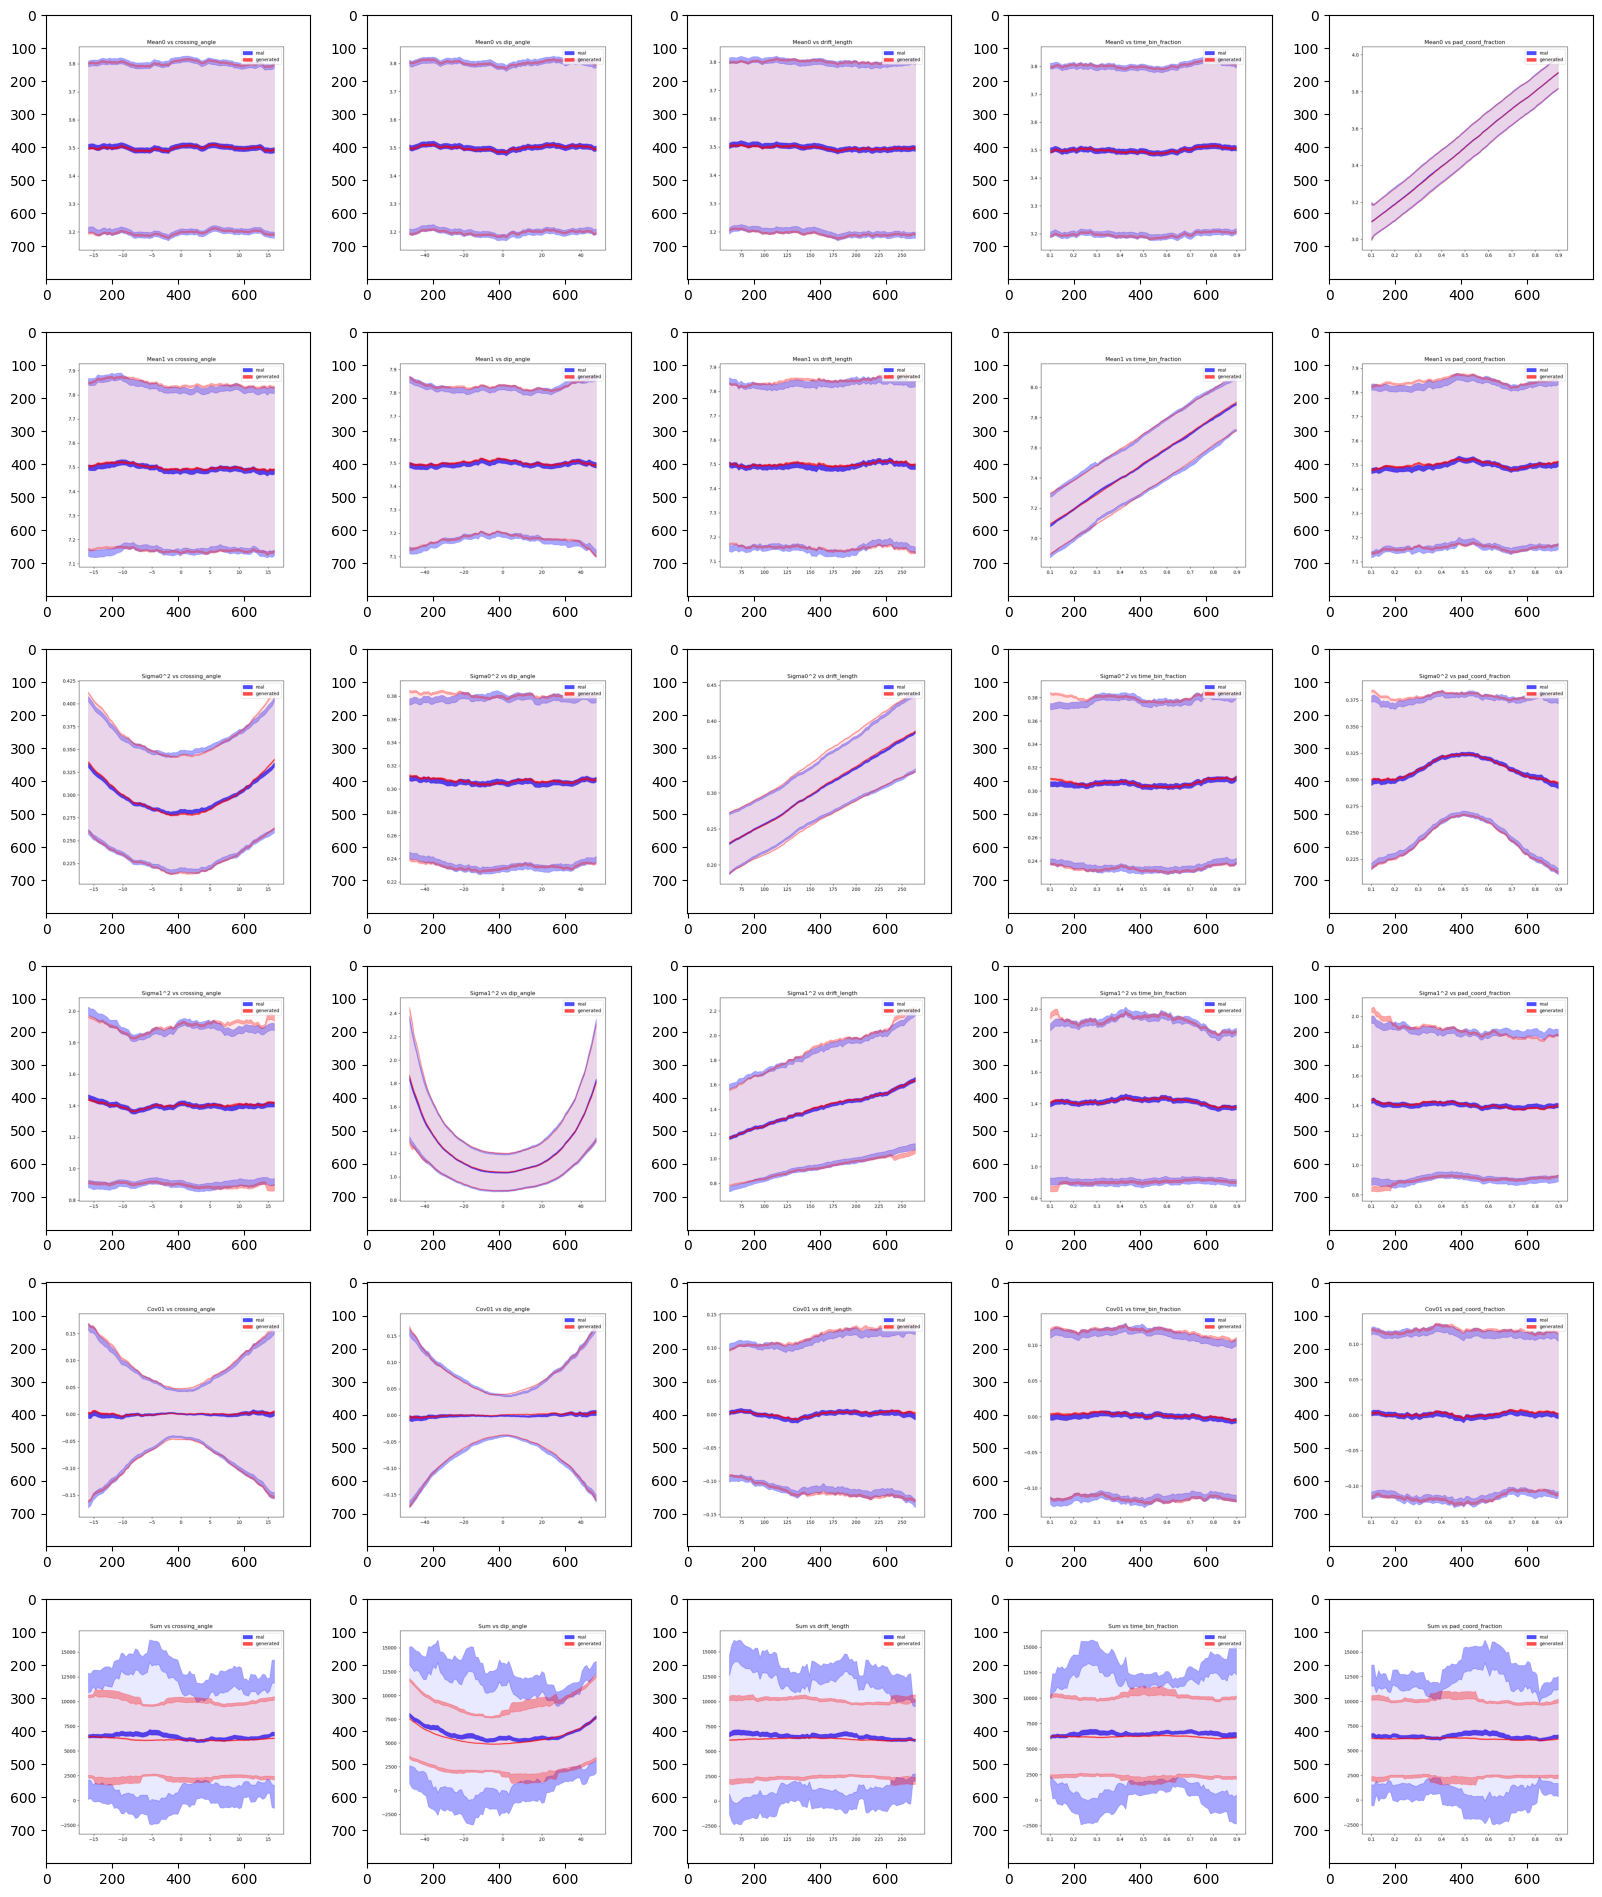

In [30]:
size_x = 12
size_y = size_x / 600 * 800 * 6 * 1.2 / 4

print (size_x,size_y)

cols = 5
rows = 6
fig, axes = plt.subplots(rows,cols,figsize = (20,24))
for i in range(0,rows):
    for j in range(0,cols):
        img = plt.imread(f"tmp_results/{i},{j}.png")
        axes[i,j].imshow(img)
        axes[i,j].axis('off')